![title](images/header.png)

# Ve - Supervised Classification of eSBAE with CAFI data - multiple models
-------
This notebook performs a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler
#!pip install xgboost

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [2]:
# country area (ha)
#GAB
study_area = 26287600
#DRC
#study_area = 232798200
#COG
#study_area = 34402400
#CMR
#study_area = 46497000
#EQG
#study_area = 2685800
#CAR
#study_area = 62009300

# 1 - data preparation

## 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5e - with all the eSBAE columns

In [3]:
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,simple_combined,kmeans_chg,kmeans_def,kmeans_deg,plotid,lon,lat,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,chg_prob,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFtype,Ref_Ftype,Commentaires,collection,interpreted,Ref_LCtype,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,sampling,ISO
0,51,31,-1.000,0.000000,0.000000,2021.581,0.506586,3182.462366,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,0.750638,21.374971,60.963004,-83.864098,18103,1,246.234512,18319,1,2.409739,0,0,4.430581,0.000,0.000000,194,1.0,74.0,3.0,22.0,63.0,284.601074,10,10,2,2,2,2.0,2,0,0,NaN,91,36.0,34,21,1,1,1,1,1,0.0,0.0,10.0,10.0,POINT (10.778096601235843 -1.197510356812697),76053,NaN,NaN,NaN,1,0.016667,0.017333,0.026000,0.016667,1,1,1,76053,10.778097,-1.197510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,systematic,GAB
1,44,29,2019.370,-661.408752,-1.861164,2019.370,0.270975,10382.470690,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,-42.474946,32.004523,85.594657,-172.453678,18343,1,-402.519574,18279,1,-4.061289,18279,1,-3.962060,0.000,0.000000,266,1.0,74.0,28.0,8.0,70.0,486.137970,10,10,2,2,2,2.0,2,0,0,NaN,90,33.0,32,9,1,1,1,1,1,0.0,0.0,10.0,10.0,POINT (11.384048972224505 -0.907979628551144),100573,NaN,NaN,NaN,1,0.071333,0.030000,0.092667,0.071333,1,1,1,100573,11.384049,-0.907980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,systematic,GAB
2,40,31,2016.022,359.061890,0.440676,2022.241,0.203409,3427.817204,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,9491.010753,451.618955,7995.0,10000.0,98.214360,34.928123,184.614862,-18.083604,16832,1,-326.451333,16808,1,-2.087069,16808,1,-2.262008,0.000,0.000000,7,1.0,73.0,8.0,20.0,64.0,647.537048,10,10,2,2,2,

In [4]:
len(ceo_esbae_1522)

222878

In [5]:
ceo_esbae_1522['kmeans_chg'].value_counts(dropna=False)

kmeans_chg
1    141887
2     69505
3     11486
Name: count, dtype: int64

In [6]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Type_1522,,,,
Def,1,11,62,74
Deg,3,29,181,213
NF,66,709,591,1366
Stable,2039,3291,1390,6720
Total,2109,4040,2224,8373


In [7]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,2.0,21.0,23
Def2017,NaN,3.0,11.0,14
Def2018,NaN,NaN,8.0,8
Def2019,NaN,NaN,2.0,2
Def2020,NaN,1.0,6.0,7
Def2021,NaN,1.0,6.0,7
Def2022,1.0,4.0,8.0,13
Deg2016,NaN,4.0,14.0,18
Deg2017,NaN,1.0,19.0,20


In [9]:
all_ceo_cols = ceo_esbae_1522.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',

In [10]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
'bfast_change_date', 'bfast_magnitude', 'bfast_means', 
    'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
    'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
    'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
    'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
    'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
    'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
    'ccdc_change_date', 'ccdc_magnitude', 'aspect', 
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
    'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
    'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
    'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub',]

In [11]:
df = ceo_esbae_1522

### 1.2 where/what are NAs
evaluate and replace no data values

In [12]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [13]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [14]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [15]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [16]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    214505
1.0      6720
0.0      1653
Name: count, dtype: int64

In [17]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [18]:
interpreted = gdf[gdf['interpreted'] == 1]

### 1.3 Run classifications on entire eSBAE dataset trained with CEO interpreted data

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [19]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.8054460766750269


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

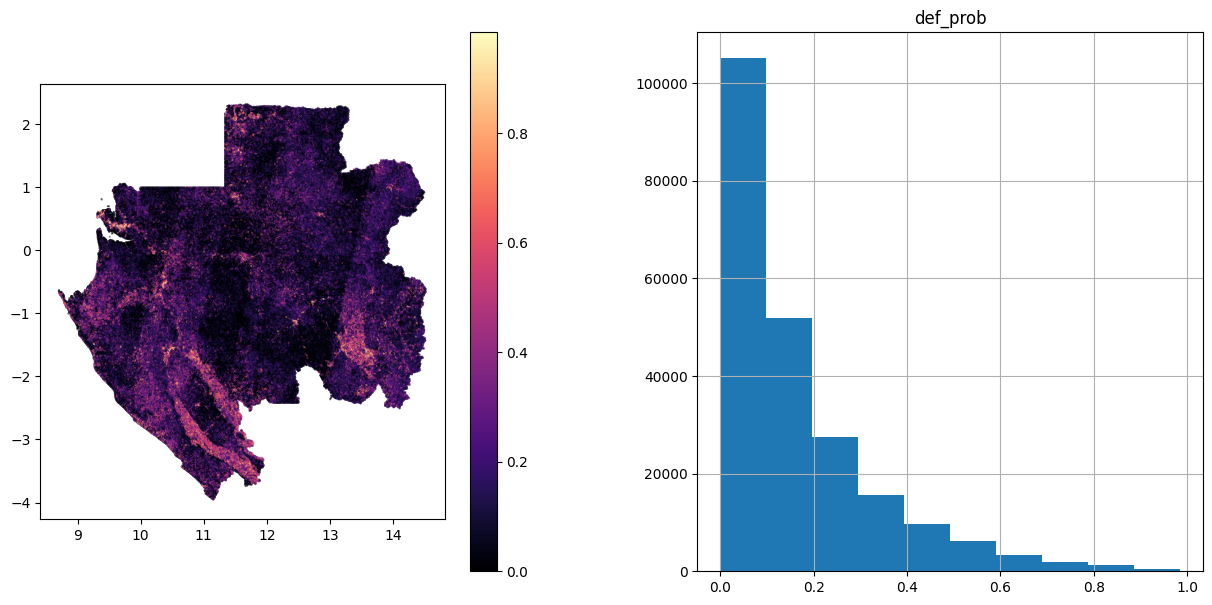

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [21]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.8232413710736892


array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

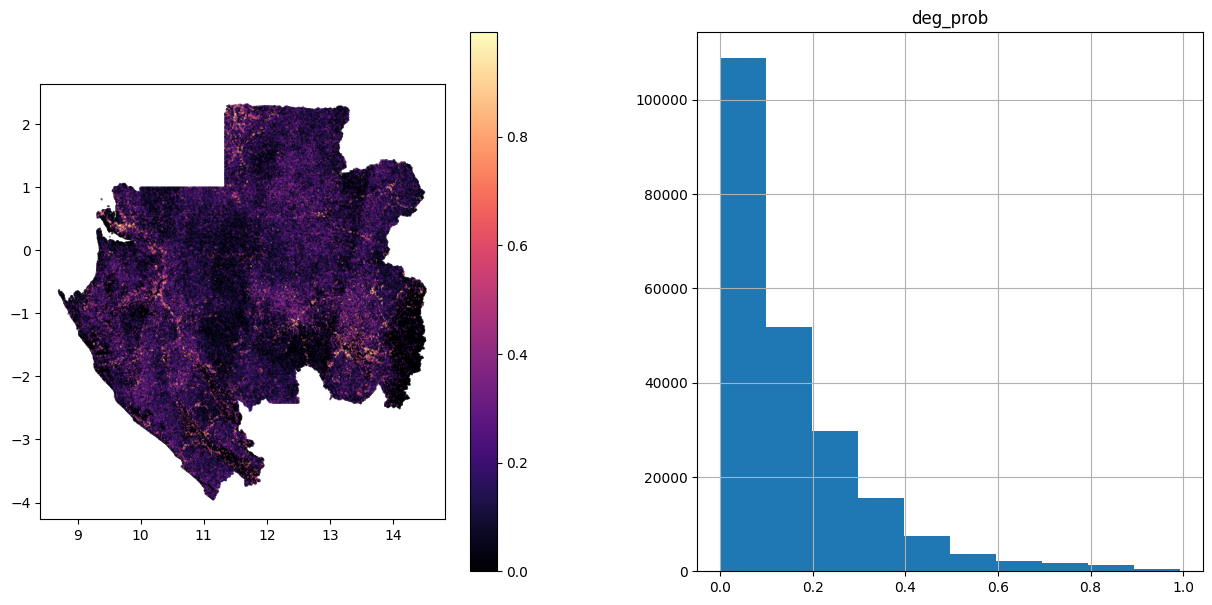

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [23]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.8839125761375851


array([<Axes: title={'center': 'stable_prob'}>], dtype=object)

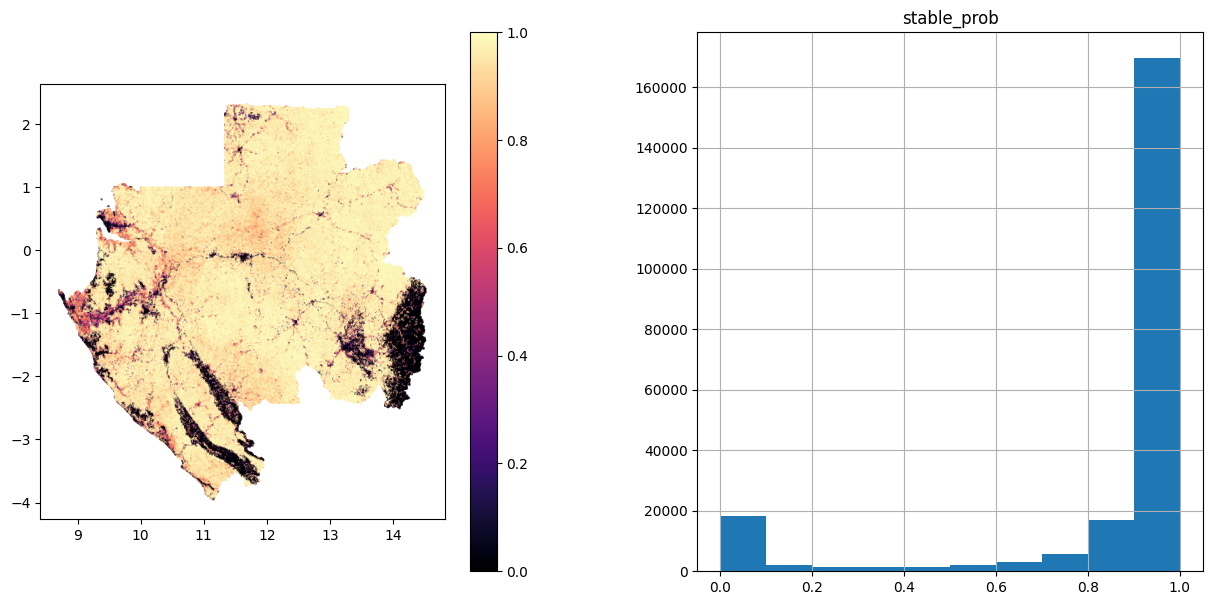

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [25]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.8928786152065256


array([<Axes: title={'center': 'nf_prob'}>], dtype=object)

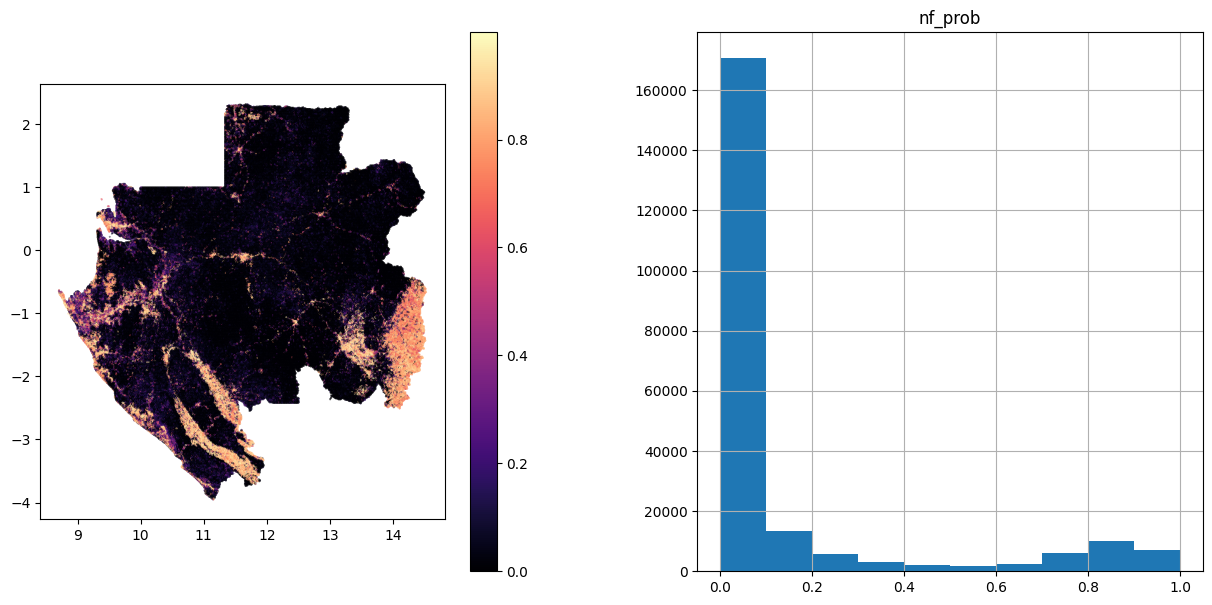

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [27]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

##### looking at validated data in comparison to model

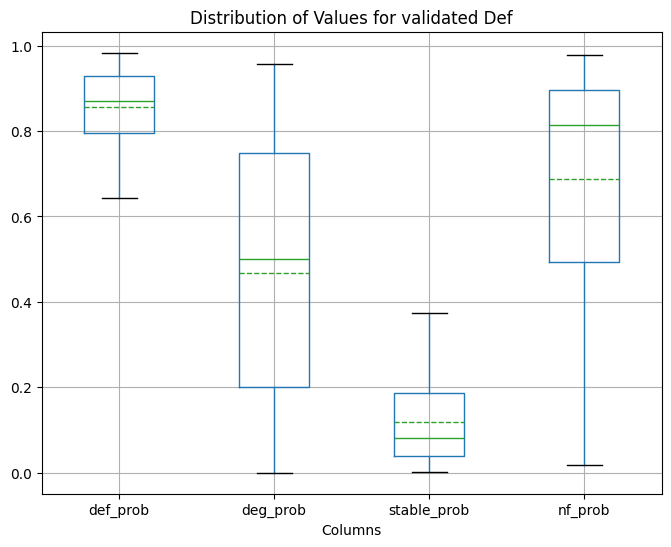

        def_prob   deg_prob  stable_prob    nf_prob
count  74.000000  74.000000    74.000000  74.000000
mean    0.855685   0.467396     0.119054   0.687315
std     0.087035   0.301067     0.102802   0.289829
min     0.643333   0.000000     0.002000   0.018667
25%     0.796000   0.199500     0.038167   0.492833
50%     0.870667   0.501333     0.080667   0.813333
75%     0.930167   0.748167     0.186000   0.896833
max     0.984000   0.958000     0.373333   0.977333


In [28]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

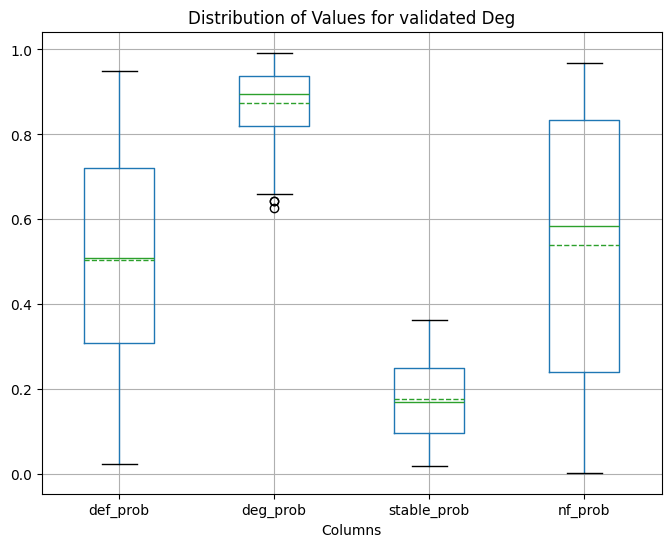

         def_prob    deg_prob  stable_prob     nf_prob
count  213.000000  213.000000   213.000000  213.000000
mean     0.504651    0.874510     0.175399    0.540156
std      0.250911    0.089786     0.091683    0.311632
min      0.023333    0.626000     0.017333    0.002667
25%      0.308000    0.820667     0.096000    0.238667
50%      0.508667    0.895333     0.169333    0.584667
75%      0.721333    0.937333     0.248667    0.834000
max      0.950000    0.992667     0.362000    0.967333


In [29]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

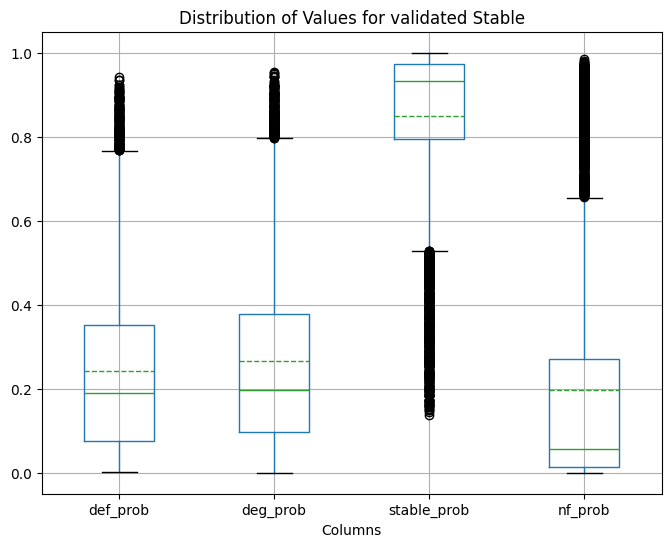

          def_prob     deg_prob  stable_prob      nf_prob
count  6720.000000  6720.000000  6720.000000  6720.000000
mean      0.240705     0.266308     0.849128     0.197445
std       0.203962     0.219874     0.187223     0.274641
min       0.001333     0.000000     0.136000     0.000000
25%       0.074667     0.096667     0.794000     0.013333
50%       0.188333     0.197333     0.933333     0.055333
75%       0.351333     0.376833     0.972000     0.270000
max       0.941333     0.954000     1.000000     0.984000


In [30]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

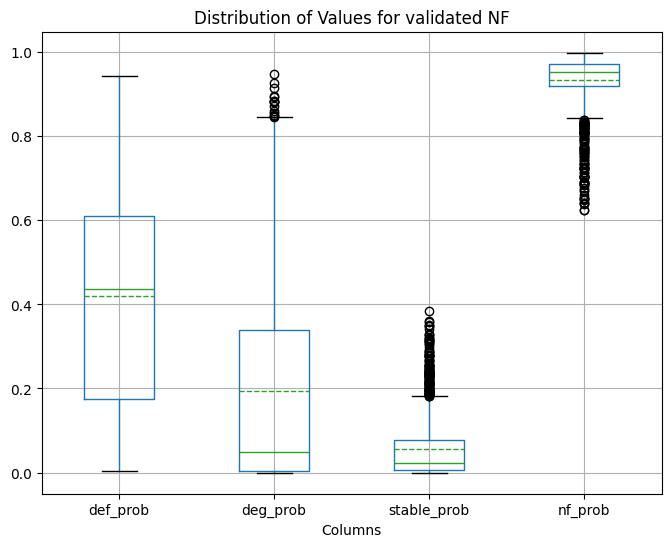

          def_prob     deg_prob  stable_prob      nf_prob
count  1366.000000  1366.000000  1366.000000  1366.000000
mean      0.419001     0.193729     0.056305     0.933204
std       0.252202     0.251991     0.073918     0.062843
min       0.004667     0.000000     0.000000     0.623333
25%       0.174833     0.002667     0.006667     0.918667
50%       0.437667     0.048667     0.022667     0.953333
75%       0.610333     0.339833     0.076667     0.972667
max       0.942000     0.948000     0.385333     0.998667


In [31]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [32]:
threshold = 0.8

In [33]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [71]:
gdf['max_prob'] = gdf[['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']].idxmax(axis=1)

# Replace the string in a specific column ('column_name')
gdf['max_prob'] = gdf['max_prob'].str.replace('_prob', '')

gdf['max_prob'].value_counts(dropna=False)

max_prob
stable    195174
nf         24612
deg         2562
def          530
Name: count, dtype: int64

In [72]:
# Calculate the proportions and areas based on max probability classification
prob_counts = gdf['max_prob'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

          Value Counts  Percentage of Total Rows     area
max_prob                                                 
stable          195174                        88 23020020
nf               24612                        11  2902890
deg               2562                         1   302178
def                530                         0    62511


In [36]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in the Gabon case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'Stable'
    elif row['sim_def'] >= 1:
        return 'Def'
    elif row['sim_deg'] >= 1:
        return 'Deg'
    else:
        return 'NF'

# Apply the function to create a new 'classification' column
gdf['prob_class'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['prob_class'].value_counts(dropna=False)

prob_class
Stable    186563
NF         33518
Def         1429
Deg         1368
Name: count, dtype: int64

In [37]:
# Calculate the proportions and areas based on decision tree classification
prob_counts = gdf['prob_class'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

            Value Counts  Percentage of Total Rows     area
prob_class                                                 
Stable            186563                        84 22004386
NF                 33518                        15  3953319
Def                 1429                         1   168545
Deg                 1368                         1   161350


In [38]:
# Group by the selected columns and count occurrences
result_df = gdf.groupby(['prob_class', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

   prob_class  Defall  Degall  Stable  NF  count
0         Def       0       0       0   1     97
1         Def       0       0       1   0    114
2         Def       0       1       0   0     31
3         Def       1       0       0   0     53
4         Deg       0       0       0   1     28
5         Deg       0       0       1   0    161
6         Deg       0       1       0   0    140
7         Deg       1       0       0   0      2
8          NF       0       0       0   1   1241
9          NF       0       0       1   0   1454
10         NF       0       1       0   0     42
11         NF       1       0       0   0     19
12     Stable       0       0       1   0   4991


In [39]:
# Create a new column 'Count' based on the conditions to determine if points are in multiple classes
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

col_0   Count
Count        
0       18313
1      202785
2        1434
3         346


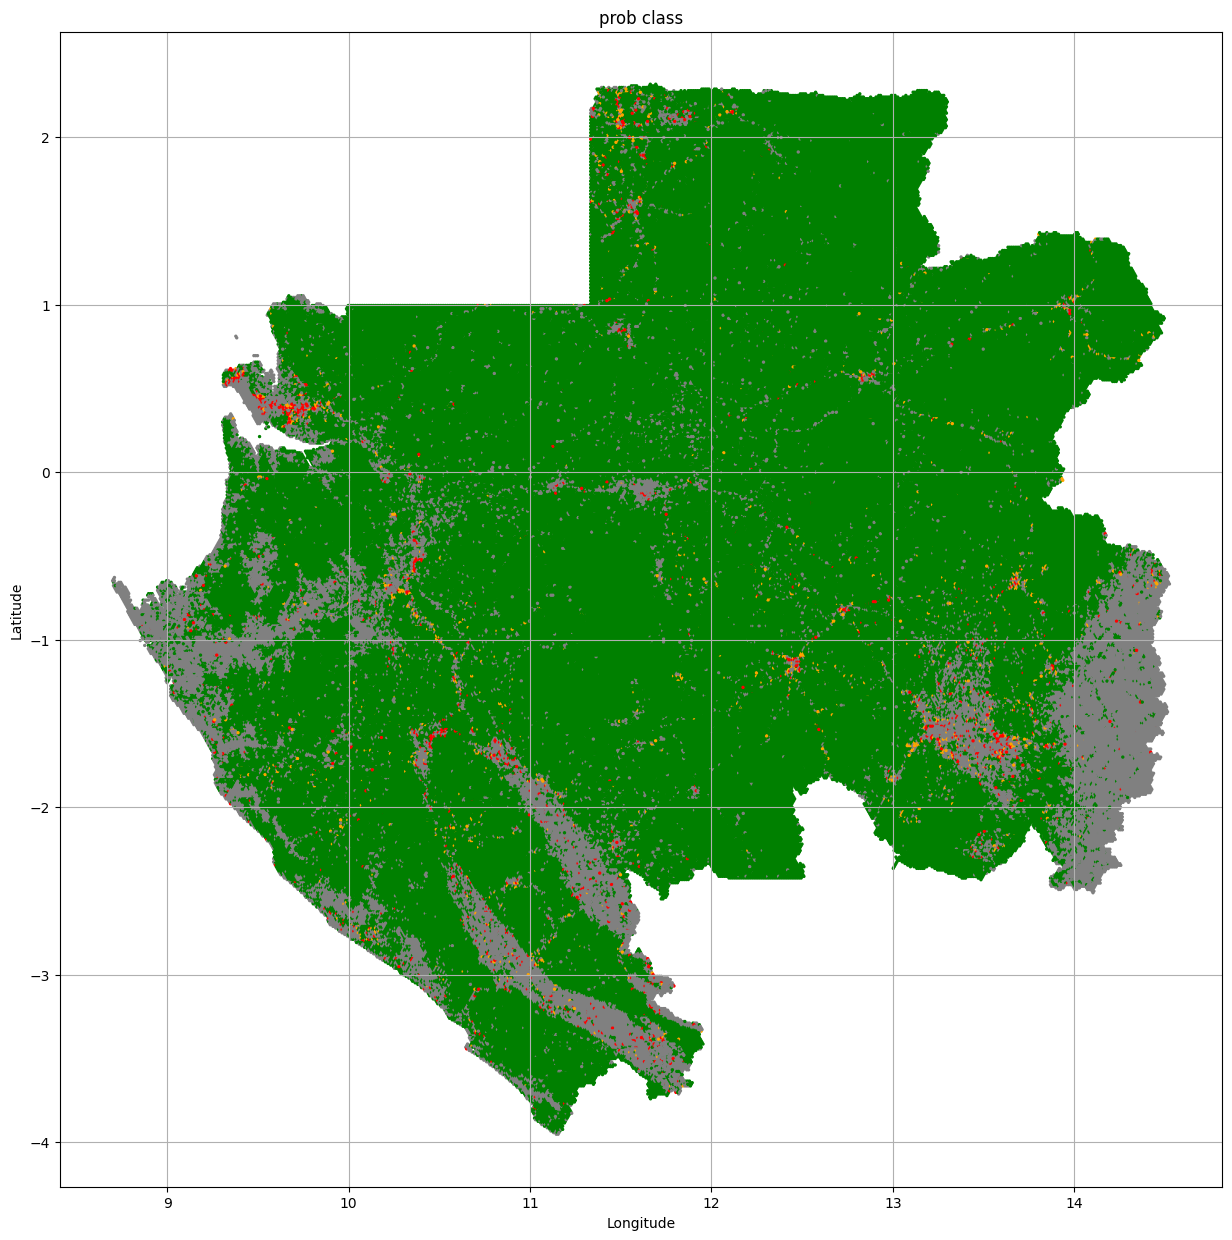

In [58]:
# plot point classes
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['prob_class'].map(category_colors), s=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('prob class')
plt.grid()
plt.show()

#### Supervised classifications

In [41]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_1522']

In [42]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [43]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

array(['Def', 'Deg', 'NF', 'Stable'], dtype=object)

In [44]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

{'Def': 27.008064516129032,
 'Deg': 9.302777777777777,
 'NF': 1.5222727272727272,
 'Stable': 0.31264002987303957}

In [46]:
#Balanced random forest classifier
#clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.04      0.58      0.07        12
         Deg       0.09      0.55      0.15        33
          NF       0.83      0.66      0.74       266
      Stable       0.98      0.77      0.86      1364

    accuracy                           0.75      1675
   macro avg       0.48      0.64      0.45      1675
weighted avg       0.93      0.75      0.82      1675



In [47]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7450746268656716


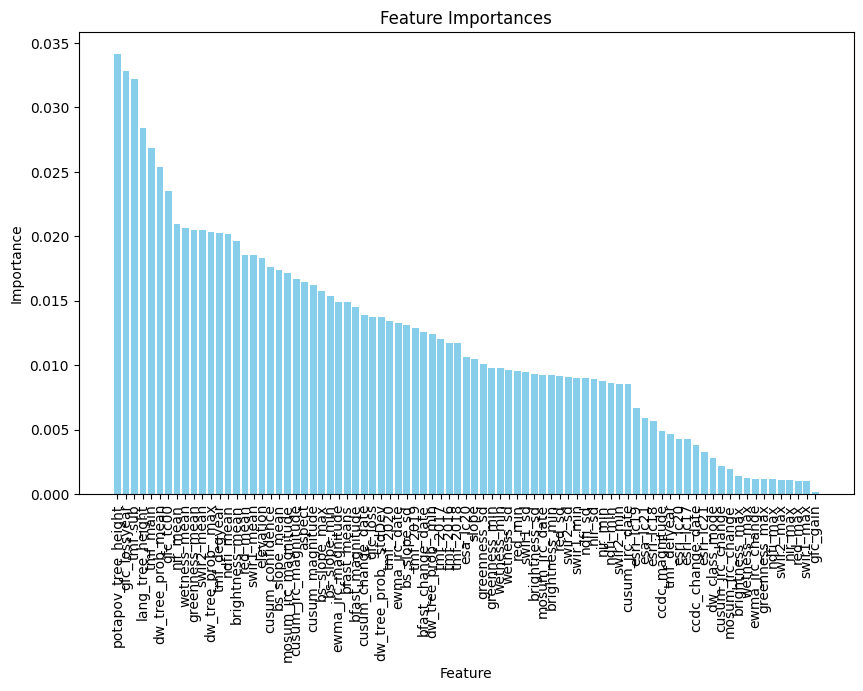

In [48]:
# Get feature importances
importances = clf.feature_importances_

# Get column names
column_names = X_train.columns

# Sort feature importances in descending order
indices = (-importances).argsort()

# Plot feature importances with column names
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), column_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [49]:
# Calculate the proportions of classified points
value_counts = gdf['balRF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

            Value Counts  Percentage of Total Rows     area
balRF_pred                                                 
Stable            191527                        86 22589871
NF                 20081                         9  2368476
Deg                 5664                         3   668047
Def                 5606                         3   661206


In [50]:
# Create an instance of the random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=42, oob_score=True) # too low
clf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=class_weight_dict)
# Fit the classifier to your training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Make predictions on new data
gdf['RF_pred'] = clf.predict(gdf[eSBAE_cols])

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.00      0.00      0.00        12
         Deg       1.00      0.03      0.06        33
          NF       0.87      0.71      0.78       266
      Stable       0.92      0.98      0.95      1364

    accuracy                           0.91      1675
   macro avg       0.70      0.43      0.45      1675
weighted avg       0.91      0.91      0.90      1675



In [51]:
# Calculate the proportions
value_counts = gdf['RF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

         Value Counts  Percentage of Total Rows     area
RF_pred                                                 
Stable         202534                        91 23888104
NF              20084                         9  2368830
Deg               198                         0    23353
Def                62                         0     7313


In [52]:
#CART Model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict on the Testing Dataset
y_pred = model.predict(X_test)
gdf['CART_pred'] = model.predict(gdf[eSBAE_cols])
# Step 4: Evaluate the Model (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

Accuracy on the test set: 0.8692537313432835
              precision    recall  f1-score   support

         Def       0.13      0.25      0.17        12
         Deg       0.14      0.18      0.16        33
          NF       0.73      0.69      0.71       266
      Stable       0.93      0.93      0.93      1364

    accuracy                           0.87      1675
   macro avg       0.48      0.51      0.49      1675
weighted avg       0.88      0.87      0.87      1675



In [53]:
# Calculate the proportions
value_counts = gdf['CART_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

           Value Counts  Percentage of Total Rows     area
CART_pred                                                 
Stable           198670                        89 23432360
NF                21277                        10  2509540
Deg                2109                         1   248748
Def                 822                         0    96952


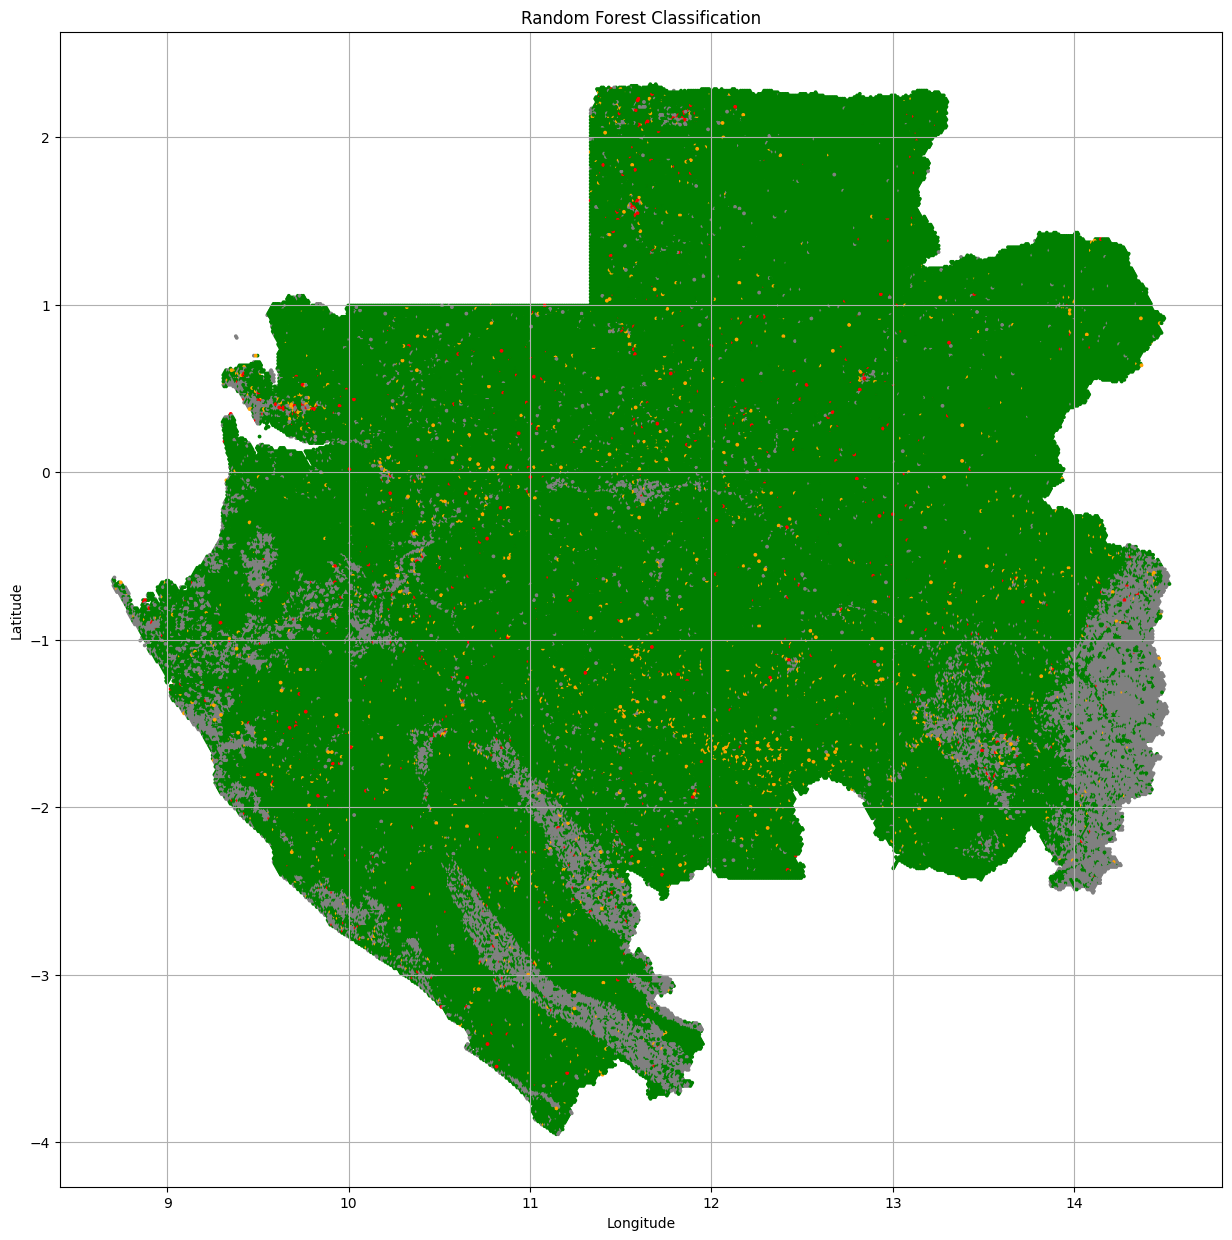

In [54]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['CART_pred'].map(category_colors), s=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

#### add years to all points

In [59]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)
gdf['ccdc_change_year'] = np.floor(gdf['ccdc_change_date']).astype(int)
gdf['bfast_change_year'] = np.floor(gdf['bfast_change_date']).astype(int)

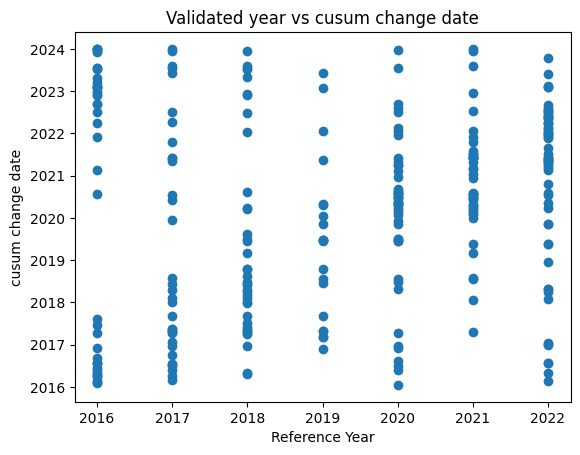

In [60]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

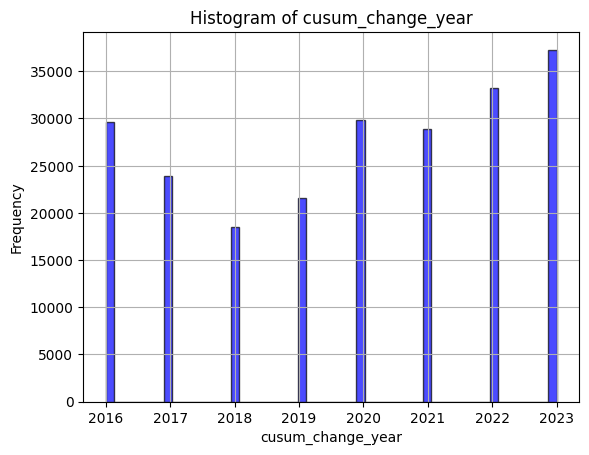

In [61]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

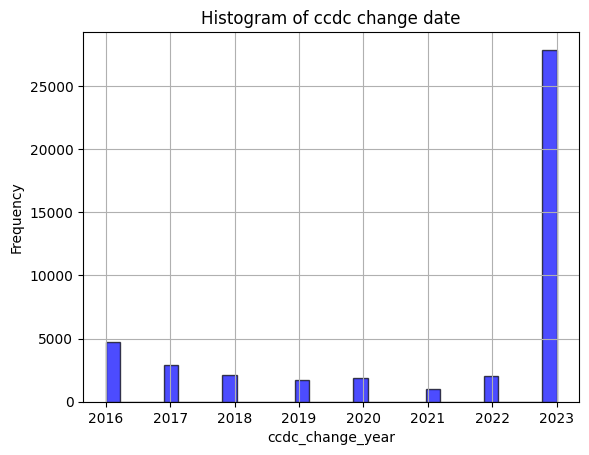

In [62]:
# plot histogram of ccfc change
gdf_ccdc = gdf[gdf['ccdc_change_year']>0]
plt.hist(gdf_ccdc['ccdc_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ccdc change date')
plt.xlabel('ccdc_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

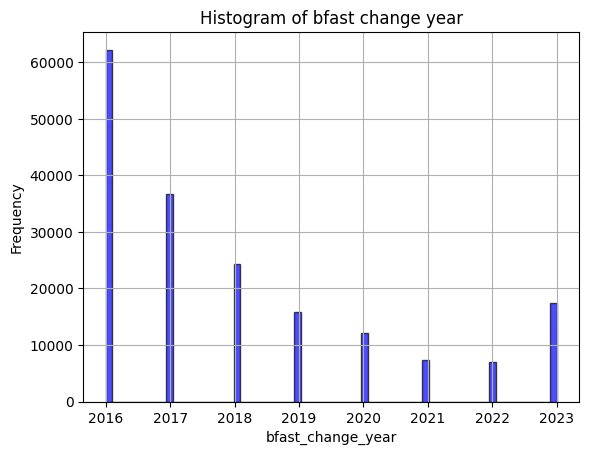

In [63]:
# plot histogram of cusum change
gdf_bfast = gdf[gdf['bfast_change_year']>0]
plt.hist(gdf_bfast['bfast_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of bfast change year')
plt.xlabel('bfast_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [78]:
#choose which model to use
model = 'CART_pred'

In [79]:
# create hybrid column taking the class from the model you choose and combining with cusum date
def y(x):
  if x[model] == 'Def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x[model] == 'Def' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Deg' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Def' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Deg' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Stable' : return 'Stable'
  elif x[model] == 'NF' : return 'NF'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

Sim_Ref_Change_Year_1522
Def2016       127
Def2017        80
Def2018        71
Def2019        83
Def2020       104
Def2021       124
Def2022       127
Deg2016       233
Deg2017       167
Deg2018       199
Deg2019       210
Deg2020       296
Deg2021       310
Deg2022       321
NF          21277
Stable     199149
Name: count, dtype: int64


In [80]:
#create hybrid column with values keeping interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf[model])
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])

In [81]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

Sim_CEO_Ref_Change_Type_1522
Stable    198676
NF         21293
Deg         2098
Def          811
Name: count, dtype: int64

In [82]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False).sort_index()

Sim_CEO_Ref_Change_Year_1522
Def2016       133
Def2017        85
Def2018        72
Def2019        80
Def2020       103
Def2021       121
Def2022       123
Deg2016       230
Deg2017       169
Deg2018       202
Deg2019       211
Deg2020       294
Deg2021       310
Deg2022       341
NF          21293
Stable     199111
Name: count, dtype: int64

In [83]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count",margins=True,
                             margins_name='Total')

interpreted,0,1,Total
Sim_CEO_Ref_Change_Year_1522,,,
Def2016,110,23,133
Def2017,71,14,85
Def2018,64,8,72
Def2019,78,2,80
Def2020,96,7,103
Def2021,114,7,121
Def2022,110,13,123
Deg2016,212,18,230
Deg2017,149,20,169


In [85]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Sim_CEO_Ref_Change_Type_1522,,,,
Def,212,258,341,811
Deg,792,416,890,2098
NF,4653,13430,3210,21293
Stable,136230,55401,7045,198676
Total,141887,69505,11486,222878


In [86]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Sim_CEO_Ref_Change_Year_1522,,,,
Def2016,30,46,57,133
Def2017,23,36,26,85
Def2018,13,18,41,72
Def2019,19,23,38,80
Def2020,33,27,43,103
Def2021,38,35,48,121
Def2022,33,40,50,123
Deg2016,81,50,99,230
Deg2017,68,25,76,169


In [87]:
#use stratum counts to calculate stats from CEO  points
pd.pivot_table(gdf,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,2,21,23
Def2017,NaN,3,11,14
Def2018,NaN,NaN,8,8
Def2019,NaN,NaN,2,2
Def2020,NaN,1,6,7
Def2021,NaN,1,6,7
Def2022,1,4,8,13
Deg2016,NaN,4,14,18
Deg2017,NaN,1,19,20


#### plot data

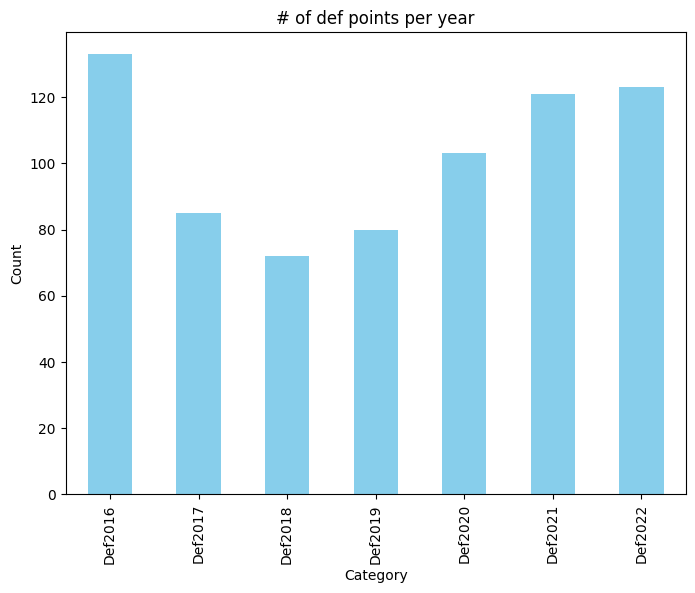

In [88]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

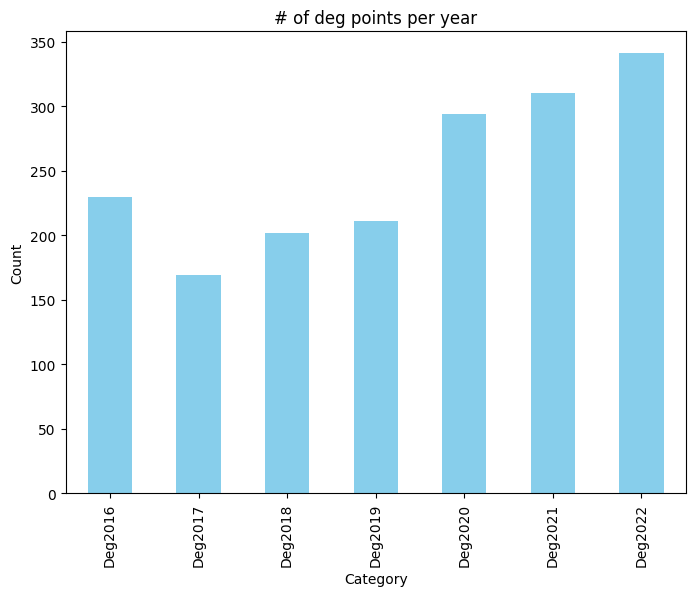

In [89]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [ ]:
#export
#out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv'
out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv'
#out_file =  '/home/sepal-user/module_results/esbae/EQG/EQG_esbae_supervised_class_1522.csv'

gdf.to_csv(out_file,index=True)